In [1]:
# Kaggle Mohs Regression Analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

In [2]:
full_train = pd.read_csv('train.csv')

In [4]:
full_train.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


## Attributes

The ID is the unique identifier
Hardness is the Target that we are trying to identify

Number of electrons: 'allelectrons' (#)<br>
Number of valence outer shell electrons: 'val_e' (#)<br>
Atomic weight: 'atomicweight' (kg/mol)<br>
First ionization energy: 'ionenergy' (J)<br>
Pauling electronegativity of most common oxidation state: 'el_neg_chi' (eV)<br>
van der Waals radius: 'R_vdw_element' (m)<br>
Covalent radius: 'R_cov_element' (m)<br>
Atomic number to mass number ratio: 'zaratio'<br>
Elemental density: 'density' (kg/m^3)<br>

In [5]:
full_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10407 non-null  int64  
 1   allelectrons_Total     10407 non-null  float64
 2   density_Total          10407 non-null  float64
 3   allelectrons_Average   10407 non-null  float64
 4   val_e_Average          10407 non-null  float64
 5   atomicweight_Average   10407 non-null  float64
 6   ionenergy_Average      10407 non-null  float64
 7   el_neg_chi_Average     10407 non-null  float64
 8   R_vdw_element_Average  10407 non-null  float64
 9   R_cov_element_Average  10407 non-null  float64
 10  zaratio_Average        10407 non-null  float64
 11  density_Average        10407 non-null  float64
 12  Hardness               10407 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.0 MB


In [7]:
full_train.isna().sum()

id                       0
allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
Hardness                 0
dtype: int64

The id is an int value and will be dropped from the training data. All others are non-null floats, and there are no nulls present in the dataset. Next look for dupes.

In [39]:
full_train.drop(['id'], axis=1)
dupes = full_train[full_train.duplicated()]

print(f' There are {len(dupes)} duplicates in the dataset')

 There are 0 duplicates in the dataset


In [40]:
len(full_train)

10407

Let's look at the distributions: 

array([[<AxesSubplot:title={'center':'allelectrons_Total'}>,
        <AxesSubplot:title={'center':'density_Total'}>,
        <AxesSubplot:title={'center':'allelectrons_Average'}>],
       [<AxesSubplot:title={'center':'val_e_Average'}>,
        <AxesSubplot:title={'center':'atomicweight_Average'}>,
        <AxesSubplot:title={'center':'ionenergy_Average'}>],
       [<AxesSubplot:title={'center':'el_neg_chi_Average'}>,
        <AxesSubplot:title={'center':'R_vdw_element_Average'}>,
        <AxesSubplot:title={'center':'R_cov_element_Average'}>],
       [<AxesSubplot:title={'center':'zaratio_Average'}>,
        <AxesSubplot:title={'center':'density_Average'}>,
        <AxesSubplot:title={'center':'Hardness'}>]], dtype=object)

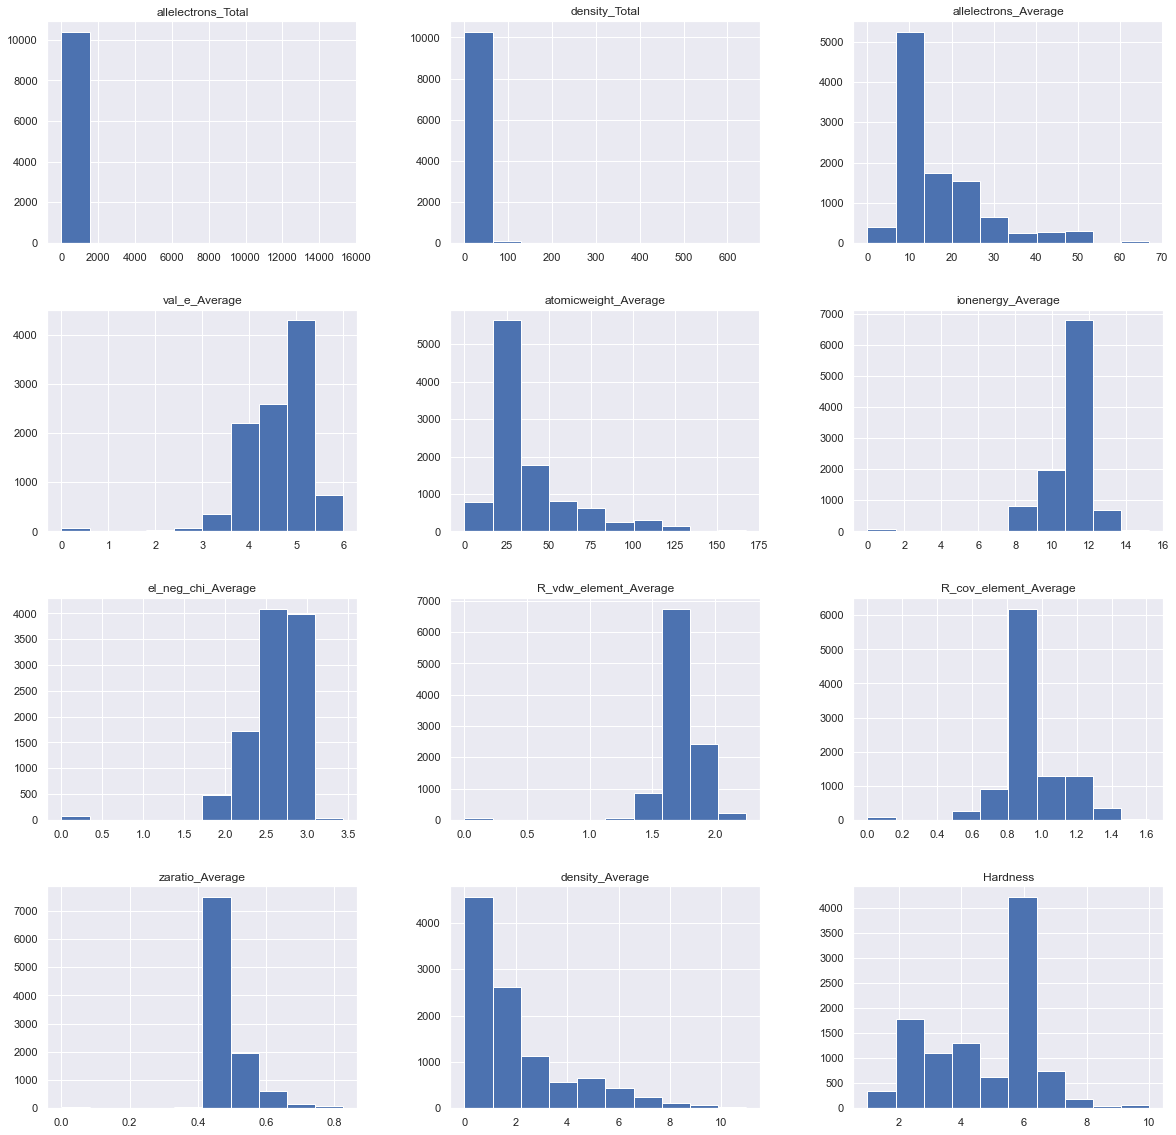

In [17]:
sns.set(rc={'figure.figsize': (20,20)})
full_train.drop(['id'], axis=1).hist()

The appearance of the allelectrons_total and the density total looks like there may be an exponential relationship, given the high number on the left and maxima orders of magnitude higher. 
Going to look at these two with log plots. 

<AxesSubplot:>

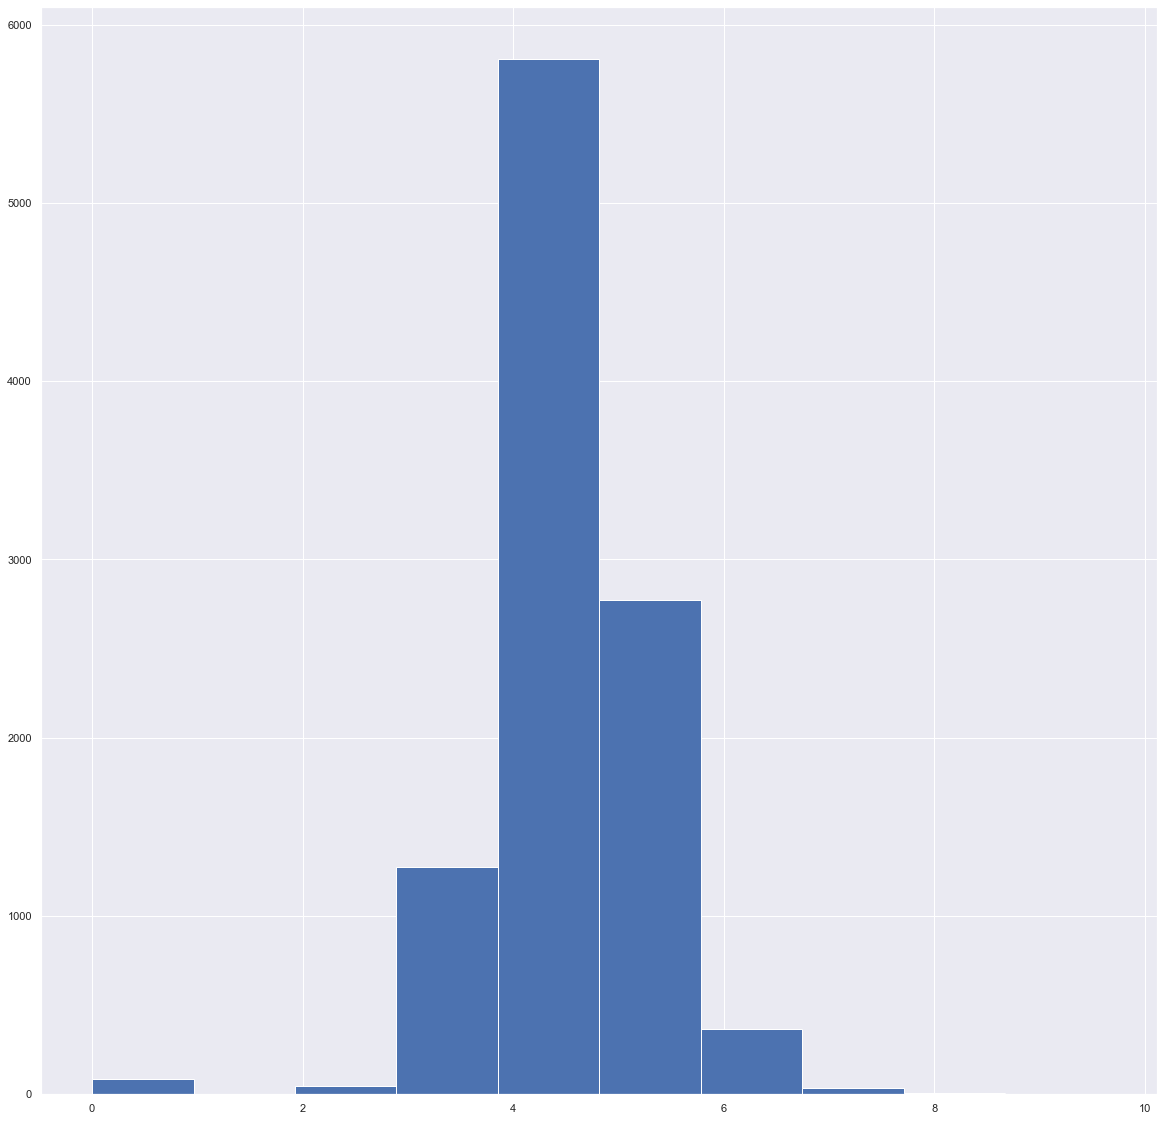

In [30]:
# All electrons total distribution

X_eT = full_train['allelectrons_Total'].apply(lambda x: np.log(x+1))
X_eT.hist()

<AxesSubplot:>

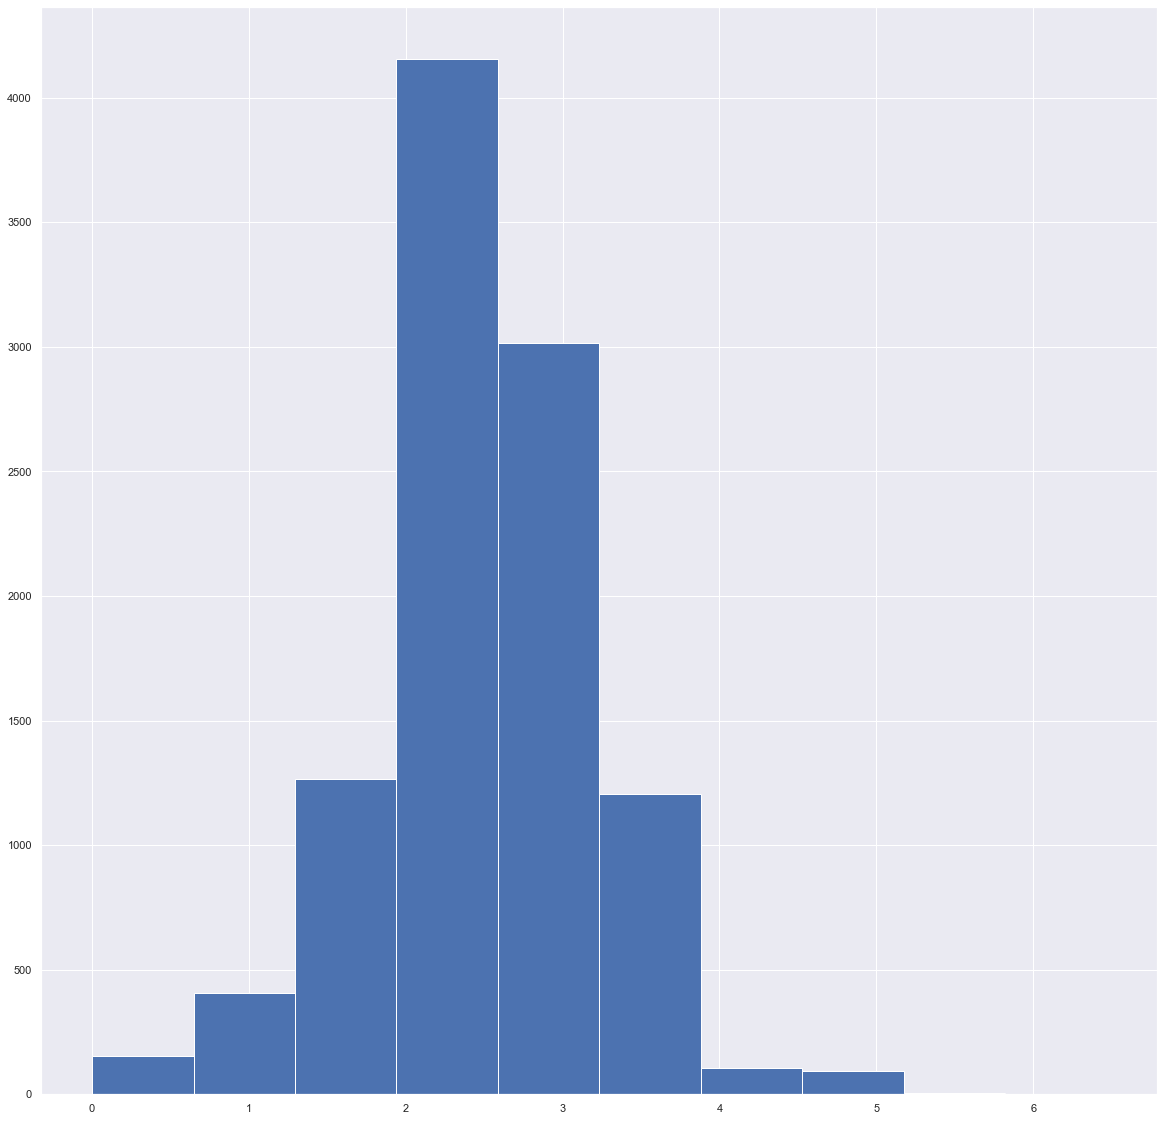

In [31]:
# Density Distribution

X_dT = full_train['density_Total'].apply(lambda x: np.log(x+1))
X_dT.hist()



***
## Look at the correlations

In [58]:
def heatmap(dataset, label = None):
    columns = list(dataset)
    corr = dataset.corr()
    plt.figure(figsize = (14, 10))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask = mask, cmap = 'crest', annot = True, linewidths = .1)
    #plt.yticks(range(len(columns)), columns, fontsize = 5)
    #plt.xticks(range(len(columns)), columns, fontsize = 5)
    plt.title(f'{label} Dataset Correlation Matrix\n', fontsize = 25, weight = 'bold')
    plt.show()

In [51]:
X = full_train.drop(['id'], axis=1)

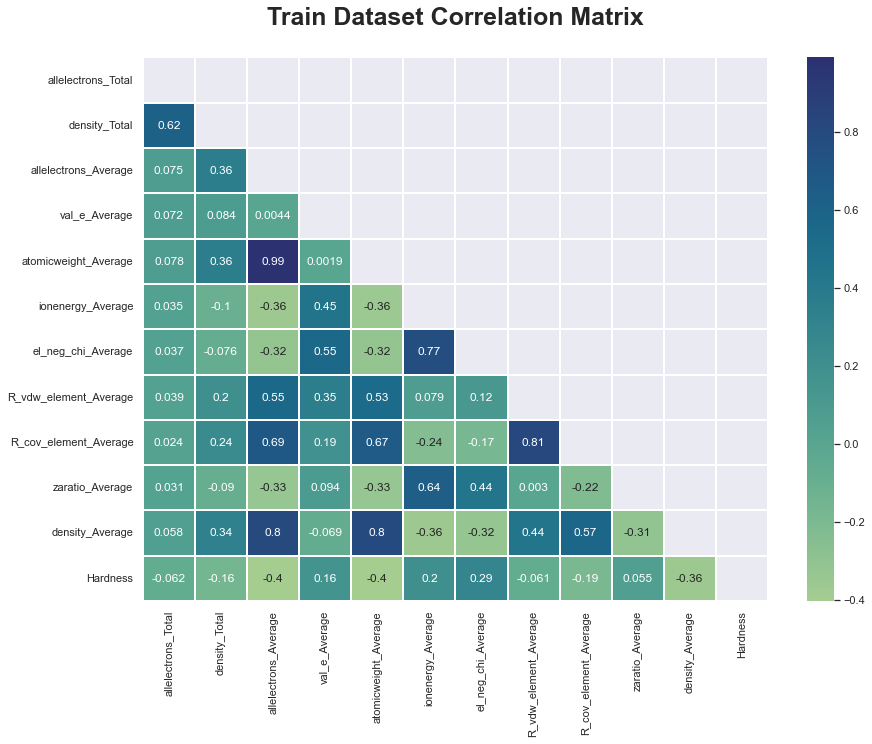

In [59]:
heatmap(X, 'Train')

- It should be noted that, not surprisingly, there is a very strong correlation with the atomic weight and number of electrons. 
- The atomic weight is based on the number of protons and neutrons in a molecule, and while the neutrons have some flexibility, the electrons do not - they are directly correlated with the number of protons. That being said, keeping both of these measures may not be ideal. 
- We also see similar correlation values between the allelectrons total and density total AND the allelectrons_average and density_average.
- There is a also a cubic difference between the dimensions of the radii and the density, whereas the mass and density are directly proportional. 

        van der Waals radius: 'R_vdw_element' (m)<br>
        Covalent radius: 'R_cov_element' (m)<br>
        Elemental density: 'density' (kg/m^3)<br>

- Another correlation that appears is between the Van der Waals forces and Covelant forces
    - Covelant radius is half the internuclear separation begween the nuclei of two single-bonded atoms of the SAME species (homonuclear)
    - van der Waals radius is half the distance between the closest approach of two non-bonded atoms of a given element


- The Z/A-Ratio, is the ratio fo electron density to the bulk density - determined by the average atomic number / average atomic weight 

In [47]:
def distance(data, label = ''):
    #thanks to @sergiosaharovsky for the fix
    corr = data.corr(method = 'spearman')
    dist_linkage = linkage(squareform(1 - abs(corr)), 'complete')
    
    plt.figure(figsize = (10, 8))
    dendro = dendrogram(dist_linkage, labels=data.columns, leaf_rotation=90, )
    plt.title(f'Feature Distance in {label} Dataset', weight = 'bold', size = 22)
    plt.show()

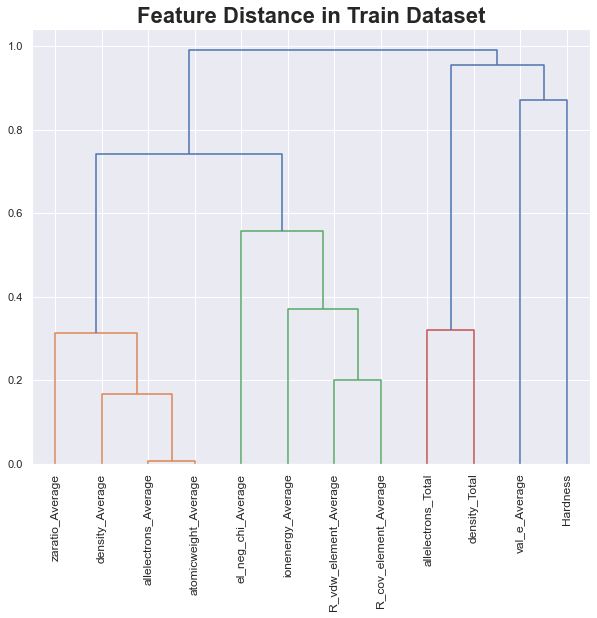

In [49]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

distance(X, 'Train')

In [61]:
from time import time
import pprint
import joblib
from functools import partial

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Classifier/Regressor
from xgboost import XGBRegressor, DMatrix

# Model selection
from sklearn.model_selection import KFold, StratifiedKFold

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

# Data processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [62]:
X_train = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')

In [63]:
y_train = X_train.Hardness
X_train = X_train.set_index('id').drop('Hardness', axis=1)
X_test = X_test.set_index('id')

In [68]:
# Stratifying the target
y_stratified = pd.cut(y_train.rank(method='first'), bins=10, labels=False)

In [69]:
# Winsorizing lower bounds
from scipy.stats.mstats import winsorize
y_train = np.array(winsorize(y_train, [0.002, 0.0]))

In [70]:
# Pointing out categorical features
categoricals = [item for item in X_train.columns if 'cat' in item]

In [71]:
categoricals

[]

In [73]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    
    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
        
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start, 
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [74]:
# Setting the scoring function
scoring = make_scorer(partial(mean_squared_error, squared=False), 
                      greater_is_better=False)

In [75]:
# Setting the validation strategy
skf = StratifiedKFold(n_splits=7,
                      shuffle=True, 
                      random_state=0)

cv_strategy = list(skf.split(X_train, y_stratified))

In [76]:
# Setting the basic regressor
reg = XGBRegressor(random_state=0, booster='gbtree', objective='reg:squarederror', tree_method='gpu_hist')

In [77]:
# Setting the search space
search_spaces = {'learning_rate': Real(0.01, 1.0, 'uniform'),
                 'max_depth': Integer(2, 12),
                 'subsample': Real(0.1, 1.0, 'uniform'),
                 'colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
                 'reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
                 'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
                 'n_estimators': Integer(50, 5000)
   }

In [78]:
# Wrapping everything up into the Bayesian optimizer
opt = BayesSearchCV(estimator=reg,                                    
                    search_spaces=search_spaces,                      
                    scoring=scoring,                                  
                    cv=cv_strategy,                                           
                    n_iter=120,                                       # max number of trials
                    n_points=1,                                       # number of hyperparameter sets evaluated at the same time
                    n_jobs=1,                                         # number of jobs
                    iid=False,                                        # if not iid it optimizes on the cv score
                    return_train_score=False,                         
                    refit=False,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=0)                                   # random state for replicability

In [80]:
# Running the optimizer
overdone_control = DeltaYStopper(delta=0.01)                    # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60*4)          # We impose a time limit (7 hours)

best_params = report_perf(opt, X_train, y_train,'XGBoost_regression', 
                          callbacks=[overdone_control, time_limit_control])

XGBoost_regression took 203.38 seconds,  candidates checked: 6, best CV score: -1.215 ± 0.018
Best parameters:
OrderedDict([('colsample_bytree', 0.5758225678679059),
             ('learning_rate', 0.06731886525659495),
             ('max_depth', 5),
             ('n_estimators', 998),
             ('reg_alpha', 24.04631523135751),
             ('reg_lambda', 34.21270253201294),
             ('subsample', 0.6778671495585501)])



In [85]:
# Transferring the best parameters to our basic regressor
reg = XGBRegressor(random_state=0, booster='gbtree', objective='reg:squarederror', tree_method='gpu_hist', **best_params)

In [86]:
# Cross-validation prediction
folds = 10
skf = StratifiedKFold(n_splits=folds,
                      shuffle=True, 
                      random_state=0)

predictions = np.zeros(len(X_test))
rmse = list()

for k, (train_idx, val_idx) in enumerate(skf.split(X_train, y_stratified)):
    reg.fit(X_train.iloc[train_idx, :], y_train[train_idx])
    val_preds = reg.predict(X_train.iloc[val_idx, :])
    val_rmse = mean_squared_error(y_true=y_train[val_idx], y_pred=val_preds, squared=False)
    print(f"Fold {k} RMSE: {val_rmse:0.5f}")
    rmse.append(val_rmse)
    predictions += reg.predict(X_test).ravel()
    
predictions /= folds
print(f"repeated CV RMSE: {np.mean(rmse):0.5f} (std={np.std(rmse):0.5f})")

Fold 0 RMSE: 1.22302
Fold 1 RMSE: 1.18692
Fold 2 RMSE: 1.21225
Fold 3 RMSE: 1.19916
Fold 4 RMSE: 1.19564
Fold 5 RMSE: 1.19848
Fold 6 RMSE: 1.20304
Fold 7 RMSE: 1.23550
Fold 8 RMSE: 1.18525
Fold 9 RMSE: 1.28745
repeated CV RMSE: 1.21267 (std=0.02899)


In [87]:
# Preparing the submission
submission = pd.DataFrame({'id':X_test.index, 
                           'target': predictions})

In [89]:
submission.to_csv("submission.csv", index = False)

In [90]:
submission

,id,target
0,10407,2.760790
1,10408,2.758419
2,10409,5.897082
3,10410,3.782720
4,10411,4.856478
...,...,...
6934,17341,5.900247
6935,17342,4.164602
6936,17343,4.959917
6937,17344,4.429164
